In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import glob
%matplotlib inline

# Camera calibration

In [2]:
from camera_calibrator import CameraCalibrator

In [3]:
camera_calibrator = CameraCalibrator(9, 6, images=glob.glob('camera_cal/calibration*.jpg'))
camera_calibrator.calibrate_camera()

Camera ready!


### Test the calibration

In [4]:
test_camera_calibration = False

global test_images
test_images = glob.glob('test_images/*')
undistored_images = []
for path in test_images:
    img = mpimg.imread(path)
    undistored_images.append(camera_calibrator.undistort_image(img))
    if test_camera_calibration:
        camera_calibrator.plot_calibration_check(img)

# Pipeline 

In [5]:
from gradient_threshold import GradientThreshold
from lane_lines import LaneLines

In [6]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import io
import base64

### util methods

In [7]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, np.int32(vertices), ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def convert_to_hsv(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    hsv[:, :, 1] = clahe.apply(hsv[:, :, 1])
    return hsv

def apply_color_threshold(img, thresh=None):
    h = img[:,:,0]
    s = img[:,:,1]
    v = img[:,:,2]
    h_thresh = thresh[0]
    s_thresh = thresh[1]
    v_thresh = thresh[2]
    color_thr_result = np.zeros_like(img[:,:,1])
    color_thr_result[(h >= h_thresh[0]) & (h <= h_thresh[1]) & 
               (s >= s_thresh[0]) & (s <= s_thresh[1]) & 
               (v >= v_thresh[0]) & (v <= v_thresh[1])] = 1
    return color_thr_result

def warp_image(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped_imge = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped_imge, Minv

def get_color_gradient_combined(grad_combined, color_combined):
    combined = np.zeros_like(grad_combined)
    combined[(grad_combined==1) | (color_combined==1)] = 1
    return combined

In [8]:
gradient_threshold = GradientThreshold(kernel=3, thres_x=(20, 200), thres_y=(45, 150), 
                                       thres_mag=(35, 255), thres_dir=(0.7, 1.3))
lane = LaneLines()

In [9]:
src      =  np.array([[205, 720], [1160, 720], [784, 480], [560, 480]], np.float32)
vertices = [np.array([[205, 720], [1160, 720], [784, 480], [560, 480]], np.int32)]
dst = np.array([[205, 720], [1120, 720], [1120, 0], [205, 0]], np.float32)

first_color_thresh=([[18,31], [60,255], [90,255]])
second_color_thresh=([[0,57], [90,255], [180,255]])

In [10]:
def video_pipeline(img, test=False):
    
    # undistort the image
    undistored_image = camera_calibrator.undistort_image(img)
    
    # apply gradient threshold
    gt_result = gradient_threshold.get_gradient_threshold_combined(undistored_image)
    
    # apply color threshold
    hsv = convert_to_hsv(undistored_image)
    ct_result_1 = apply_color_threshold(hsv, first_color_thresh)
    ct_result_2 = apply_color_threshold(hsv, second_color_thresh)
    ct_result = ct_result_1 & ct_result_2
    
    # combine gradient and color threshold
    combined_image = get_color_gradient_combined(gt_result, ct_result)
    
    # mask the image
    masked_image = region_of_interest(combined_image, vertices)
    
    # warp the image
    binary_warped, Minv = warp_image(masked_image, src, dst)

    # Find the lane lines
    lane.lane_lines_full_search(binary_warped)
    lane_lines = lane.translate_to_real_world_image(undistored_image, binary_warped, Minv)
    
    if test:
        return combined_image, gt_result, ct_result, masked_image, binary_warped, lane, lane_lines
    else: 
        return lane_lines

### Pipeline test

IndexError: too many indices for array

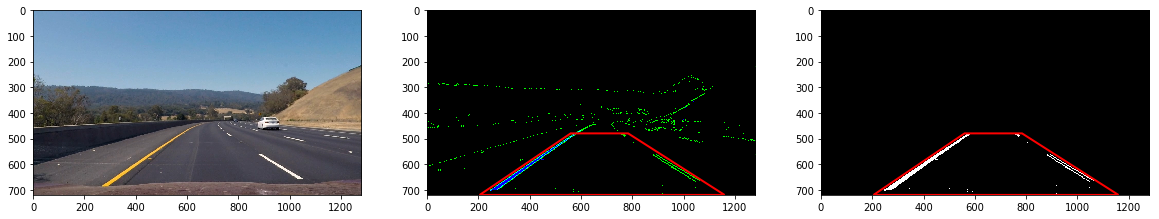

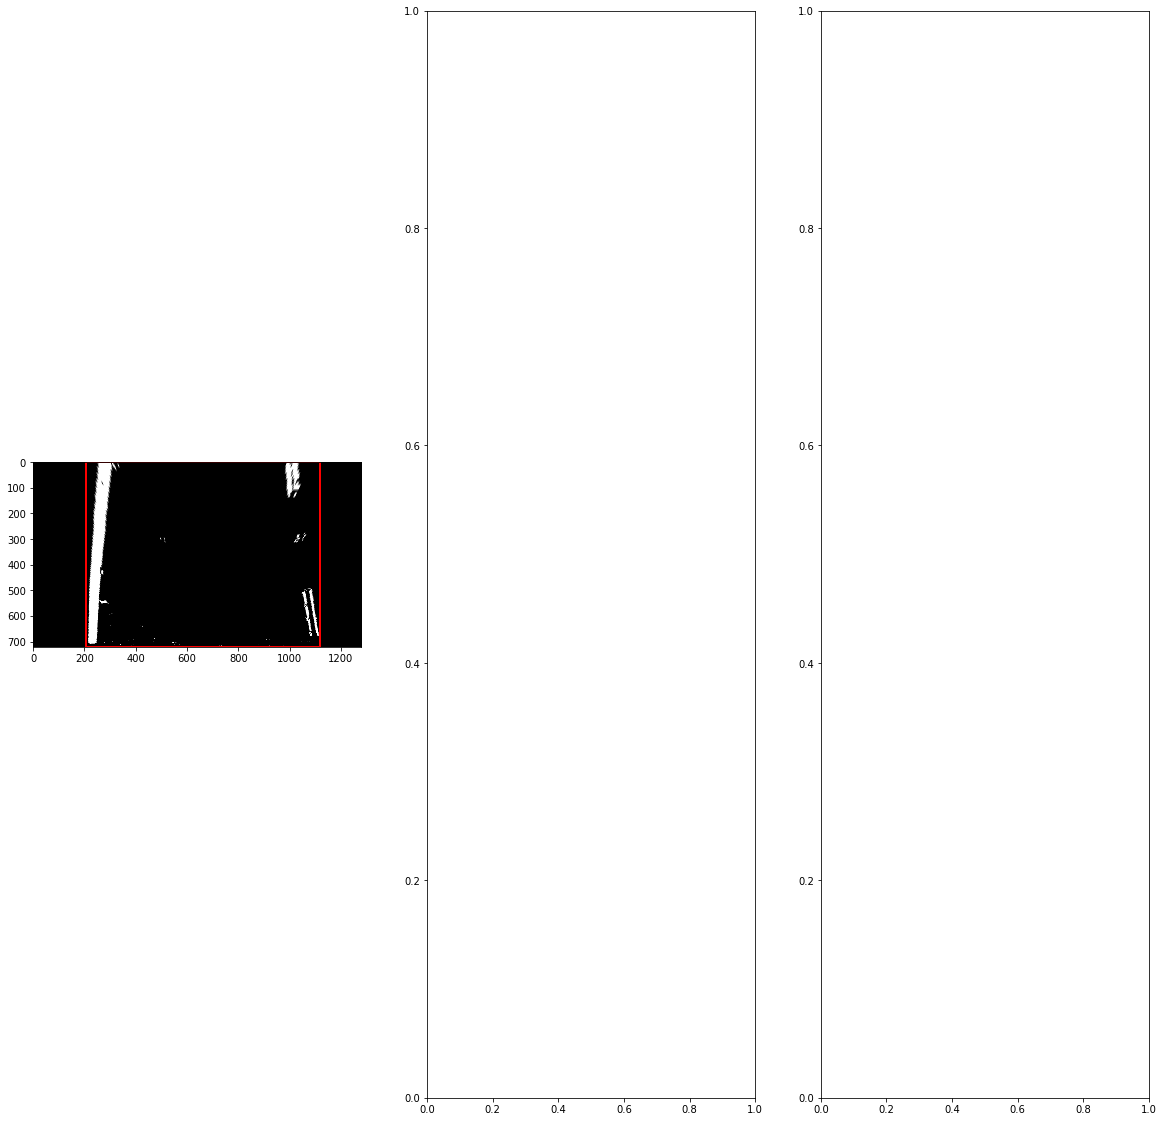

In [21]:
plot_pipeline_test = True
img_index = 4 # must be < 7

def show_test_result(test_image, gt_results, ct_results, masked_images, warps, lane, pipeline_results):
    plt.close('all')
    fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(20,20))
    img = mpimg.imread(test_image)
    ax1.imshow(img)
    stack_image = np.dstack(( np.zeros_like(gt_results), gt_results, ct_results))
    ax2.imshow(stack_image)
    rect = patches.Polygon(src, closed=True, fill=False, edgecolor='r', linewidth=2)
    ax2.add_patch(rect)
    ax3.imshow(masked_images, cmap='gray')
    rect = patches.Polygon(src, closed=True, fill=False, edgecolor='r', linewidth=2)
    ax3.add_patch(rect)
    fig2, ((ax4, ax5, ax6)) = plt.subplots(nrows=1, ncols=3, figsize=(20,20))
    ax4.imshow(warps, cmap='gray')
    rect = patches.Polygon(dst, closed=True, fill=False, edgecolor='r', linewidth=2)
    ax4.add_patch(rect)
    result, fit_leftx, fit_rightx, fity = lane.plot()
    ax5.imshow(result)
    ax5.plot(self.fit_leftx, self.fity, color='yellow', linewidth=5.0)
    ax5.plot(self.fit_rightx, self.fity, color='yellow', linewidth=5.0)
    ax5.xlim(0, 1280)
    ax5.ylim(720, 0)
    ax6.imshow(pipeline_results)
        
def test_video_pipeline():
    combined_images = []
    gt_results = [] 
    ct_results = []
    masked_images = []
    warps = []
    lanes = []
    pipeline_results = []
    for path in test_images:
        img = mpimg.imread(path)
        combined_image, gt_result, ct_result, masked_image, warped, lane, lane_lines = video_pipeline(img, True)
        combined_images.append(combined_image)
        gt_results.append(gt_result)
        ct_results.append(ct_result)
        masked_images.append(masked_image)
        warps.append(warped)
        lanes.append(lane)
        pipeline_results.append(lane_lines)
    show_test_result(test_images[img_index], gt_results[img_index], ct_results[img_index], 
                      masked_images[img_index], warps[img_index], lanes[img_index], pipeline_results[img_index])
    
if plot_pipeline_test:
    test_video_pipeline()

# Process video

In [34]:
def process_video(image):
    result = video_pipeline(image)
    return result

In [ ]:
video_output = 'output_video/project_video_output.mp4'
clip1 = VideoFileClip('project_video.mp4')

clip = clip1.fl_image(process_video)
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_video/project_video_output.mp4
[MoviePy] Writing video output_video/project_video_output.mp4


 68%|██████▊   | 863/1261 [02:54<01:16,  5.19it/s]

In [63]:
video_output = 'output_video/challenge_video_output.mp4'
clip1 = VideoFileClip('challenge_video.mp4')

clip = clip1.fl_image(process_video)
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4



 64%|██████▎   | 309/485 [01:01<00:38,  4.54it/s]


100%|██████████| 485/485 [01:38<00:00,  4.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 5min 43s, sys: 1.24 s, total: 5min 44s
Wall time: 1min 38s


In [64]:
video_output = 'output_video/harder_challenge_video_output.mp4'
clip1 = VideoFileClip('harder_challenge_video.mp4')

clip = clip1.fl_image(process_video)
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4



 25%|██▌       | 303/1200 [01:06<03:17,  4.54it/s]


 50%|█████     | 605/1200 [02:11<02:00,  4.95it/s]


 76%|███████▌  | 907/1200 [03:14<00:58,  5.05it/s]


100%|█████████▉| 1199/1200 [04:16<00:00,  4.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 14min 33s, sys: 2.68 s, total: 14min 35s
Wall time: 4min 17s
